In [22]:
import torch
import json
import os 
import urllib
import torch
from tqdm import tqdm

from transformers import GPT2Model
from gepeto.model import MODEL_ARCHITECTURES, GPTModel
from gepeto.utils import load_weights
from gepeto.train import calc_loss_loader, train_model_simple
from gepeto.token import token_ids_to_text, text_to_token_ids
from gepeto.generate import generate
from gepeto.loader import InstructionDataset, format_input, custom_collate_fn

import tiktoken
from functools import partial
from torch.utils.data import DataLoader

tokenizer = tiktoken.get_encoding('gpt2')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
        
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    
    with open(file_path, "r") as file:
        data = json.load(file)
    
    return data

file_path = "../data/instruction-data.json"

url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [3]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [4]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [6]:
model_input = format_input(data[50])

In [7]:
desired_response = f"\n\n### Response:\n{data[50]['output']}"

In [8]:
print(model_input + desired_response)

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [3]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion: train_portion+test_portion]
val_data = data[train_portion + test_portion:]

print("Training set lenght:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set lenght: 935
Validation set length: 55
Test set length: 110


In [ ]:
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [12]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device='cpu'
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [14]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device='cpu'
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [15]:
inputs, targets = custom_collate_draft_2(batch)

In [16]:
inputs

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

In [17]:
targets

tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])

In [19]:
inputs, targets = custom_collate_fn(batch)

In [20]:
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [21]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],
    [-0.5, 1.5]
    ]
)

targets_1 = torch.tensor([0, 1])
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [22]:
logits_2 = torch.tensor(
    [
        [-1.0, 1.0],
        [-0.5, 1.5],
        [-0.5, 1.5],
    ]
)

targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [23]:
logits_3 = torch.tensor(
    [
        [-1.0, 1.0],
        [-0.5, 1.5],
        [-0.5, 1.5],
    ]
)

targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)

tensor(1.1269)


In [5]:
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [6]:

num_workes = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workes
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workes
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workes
)

In [26]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [27]:
gpt_pretrained = GPT2Model.from_pretrained("openai-community/gpt2-medium", cache_dir="checkpoints")

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

In [28]:
base_configs = MODEL_ARCHITECTURES['gpt2-medium']

custom_configs = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,  # Dropout rate
    "qkv_bias": True,  # Query-Key-Value bias
}

model_configs = base_configs | custom_configs

In [29]:
gpt = GPTModel(model_configs) # Create an empty model


In [30]:
gpt = GPTModel(model_configs) # Create an empty model
load_weights(gpt, gpt_pretrained, model_configs) # Transfer the parameters from HuggingFace's model to our empty model
gpt.to(device) # Send the computation to GPU

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_decoders): Sequential(
    (0): TransformerDecoder(
      (multi_head_attention): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (norm_layer1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (norm_layer2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (feed_foward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )


In [31]:
torch.manual_seed(123)

input_text = format_input(val_data[0])

print(input_text)

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [32]:
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids(input_text, tokenizer).to(device),
    max_new_tokens=35,
    context_size=model_configs["context_length"],
    eos_id=50256,
)

generated_text = token_ids_to_text(token_ids, tokenizer)    

In [33]:
response_text = generated_text[len(input_text):].strip()

In [34]:
print(response_text)

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active


In [35]:
gpt.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, gpt, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, gpt, device, num_batches=5
    )

In [36]:
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 4.01228551864624
Validation loss: 3.9374598979949953


In [37]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    gpt,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[0]),
    tokenizer=tokenizer,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f'Training completed in {execution_time_minutes:.2f} minutes.')

Epoch 1 (Step 000000): Train loss 2.774, Val loss 2.753
Epoch 1 (Step 000005): Train loss 1.206, Val loss 1.137
Epoch 1 (Step 000010): Train loss 0.871, Val loss 0.968
Epoch 1 (Step 000015): Train loss 0.856, Val loss 0.906
Epoch 1 (Step 000020): Train loss 0.788, Val loss 0.910
Epoch 1 (Step 000025): Train loss 0.774, Val loss 0.865
Epoch 1 (Step 000030): Train loss 0.801, Val loss 0.841
Epoch 1 (Step 000035): Train loss 0.716, Val loss 0.812
Epoch 1 (Step 000040): Train loss 0.669, Val loss 0.801
Epoch 1 (Step 000045): Train loss 0.633, Val loss 0.790
Epoch 1 (Step 000050): Train loss 0.663, Val loss 0.784
Epoch 1 (Step 000055): Train loss 0.763, Val loss 0.771
Epoch 1 (Step 000060): Train loss 0.720, Val loss 0.748
Epoch 1 (Step 000065): Train loss 0.651, Val loss 0.739
Epoch 1 (Step 000070): Train loss 0.530, Val loss 0.732
Epoch 1 (Step 000075): Train loss 0.566, Val loss 0.731
Epoch 1 (Step 000080): Train loss 0.604, Val loss 0.724
Epoch 1 (Step 000085): Train loss 0.511, Val los

In [40]:
from gepeto.plot import plot_values

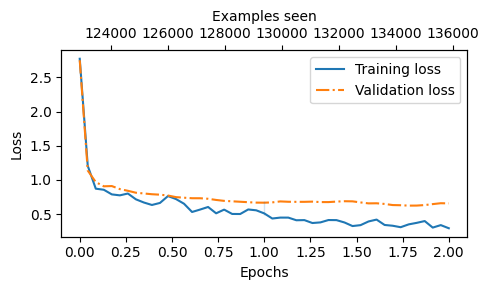

In [42]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))

plot_values(epochs_tensor, tokens_seen, train_losses, val_losses)

In [43]:
torch.manual_seed(123)

In [44]:
for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=model_configs['context_length'],
        eos_id=50256
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("---------------------------------")

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
---------------------------------
Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
---------------------------------
Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice' is J

In [46]:
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=model_configs["context_length"],
        eos_id=50256
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    test_data[i]["model_response"] = response_text

with open("../data/instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [00:43<00:00,  2.53it/s]


In [47]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


In [48]:
import re

model_filepath = "../data/gpt2-medium-sft.pth"
torch.save(gpt.state_dict(), model_filepath)

In [7]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(['name']):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError(
        "ollama not running. Launch ollama before preecending."
    )

print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [8]:
import urllib.request


def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )

    request.add_header("Content-Type", "application/json")

    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

        return response_data

In [9]:
model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories and low in fiber.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach. These treats are great for providing essential vitamins and minerals.
5. Minerals: Llamas need access to mineral supplements, which provide essential nutrients like calcium, phosphorus, and salt.

In the wild, llamas might also eat:

* Leaves from trees and shrubs
* Ba

In [12]:
with open("../data/instruction-data-with-response.json", "r") as file:
    json_data = json.load(file)

In [18]:
for entry in json_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )

    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n---------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd rate the model response "The car is as fast as a bullet." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to something else (in this case, a bullet).
* The comparison is reasonable and easy to understand. Bullets are known for their high velocity, making it a good analogy for a fast-moving car.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that some people might not immediately think of bullets when they hear "fast," and the comparison might not be as universally relatable as lightning (which is often associated with speed). However, overall, the response is well-crafted and effectively conveys the idea that the car is very fast.

---------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorm

In [25]:
def generate_model_scores(json_data, json_key, model='llama3'):
    scores = []
    for entry in tqdm(json_data, desc='Scoring entries'):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )

        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

In [26]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|██████████| 110/110 [00:08<00:00, 13.70it/s]

Number of scores: 110 of 110
Average score: 88.64

